In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["image.cmap"] = "inferno"
matplotlib.rcParams["axes.titlesize"] = 25
matplotlib.rcParams["axes.labelsize"] = 25
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.linalg


import pulse
import modulated_tls
import single_photon_emission
import two_photon_emission

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class GaussianPulse(pulse.Pulse):
    def __init__(self, pulse_amp, t_mean, t_stddev):
        self._t_mean = t_mean
        self._t_stddev = t_stddev
        self._pulse_amp = pulse_amp

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        return self._pulse_amp * np.exp(
            -(t - self._t_mean)**2 / self._t_stddev**2)
    
    
class RectangularPulse(pulse.Pulse):
    def __init__(self, pulse_amp, pulse_len):
        self._pulse_amp = pulse_amp
        self._pulse_len = pulse_len

    @property
    def period(self):
        return None
    
    def __call__(self, t) -> complex:
        if t < self._pulse_len:
            return self._pulse_amp
        else:
            return 0
        
def compute_fourier_transform(phi, times, freqs):
    df = freqs[1] - freqs[0]
    fft_matrix = np.exp(
        -1.0j * freqs[:, np.newaxis] @ times[np.newaxis, :])/ np.sqrt(2 * np.pi) * df
    return fft_matrix @ phi
    

In [5]:
# Reproducing transmission spectrum.
gamma = 98 * 1e-3
inp_freqs = np.linspace(-10, 10, 1000)


# freq_2f = 1.500
# amps = [2.910, 2.250]
# phases = [0, 0]
# harmonics = [1, 3]


# freq_2f = 1.200*2
# amps = np.array([2.360, 2.110, 2.220, 2.020, 2.250])*2
# phases = [np.pi / 6, -np.pi / 6, np.pi / 2, -5 * np.pi / 6, 5 * np.pi / 6]
# harmonics = [1, 2, 3, 4, 5]


# freq_2f = np.pi*2*10
# print(freq_2f)
# amps = [3, 0*20, 0*500]
# phases = [np.pi/2, 0, np.pi/2]
# harmonics = [1, 3, 0.01]

# delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)

pulsetimes = [-1000, 0.1/gamma]#0.0761 / gamma] #0.075 / gamma]

pulseamps = [0, 200]

delta_2f = pulse.ArbPulseConst(pulsetimes, pulseamps)

tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta_2f)

pulse_width = 0.1 / gamma
pulse_area = np.pi*2/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

#pulse_amp = 0.5* pulse_area / (np.sqrt(np.pi) * pulse_width) #* 1/np.sqrt(gamma)
#laser_pulse = GaussianPulse(pulse_amp, 5*pulse_width, pulse_width)

pulse_amp = pulse_area / (2 * pulse_width)
laser_pulse = RectangularPulse(pulse_amp, pulse_width)

times = np.linspace(0, 5 / gamma, 2000)
output_2f = two_photon_emission.two_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)

output_2fsingle = single_photon_emission.compute_single_photon_state(
        tls_obj_2f, times, laser_pulse, 1)

output_2fzero = two_photon_emission.zero_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)

print(abs(output_2fzero)**2)
print(np.sum(np.abs(output_2fsingle)**2)*(times[-1] / len(times)))
print(0.5*np.sum(np.sum(np.abs(output_2f)**2))*(times[-1] / len(times))**2)
print(1-(abs(output_2fzero)**2+np.sum(np.abs(output_2fsingle)**2)*(times[-1] / len(times))+0.5*np.sum(np.sum(np.abs(output_2f)**2))*(times[-1] / len(times))**2))

print("P2/P1")
print(0.5*(np.sum(np.sum(np.abs(output_2f)**2))*(times[-1] / len(times))**2)/(np.sum(np.abs(output_2fsingle)**2)*(times[-1] / len(times))))

0.9512258571142524
0.011889097916226122
0.036123900924763974
0.0007611440447574669
P2/P1
3.0384055358365276


0.4939969984992496


<Figure size 720x288 with 0 Axes>

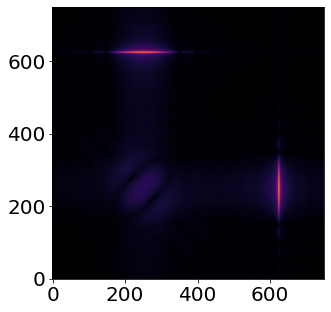

In [50]:
# plt.figure(figsize=(17, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(np.abs(output_2f_freq)**2, origin="lower", aspect=3.5,
#            extent=[times[0], times[-1], inp_freqs[0], inp_freqs[-1]])
# plt.xlabel("Time (ns)")
# plt.ylabel("Frequency (GHz)")
# plt.title(r"$|\phi(\omega, T|^2$")
# plt.subplot(1, 2, 2)
# plt.plot(inp_freqs, np.abs(output_2f_freq[:, -1])**2)
# plt.xlabel("Frequency (GHz)")
# plt.title(r"$|\phi(\omega, T \to\infty)|^2$ (GHz$^{-1}$)")
# plt.show()


fsample = np.pi/(times[1]-times[0])

pulseVals = []
for t in times:
    pulseVals.append(laser_pulse(t))
print(np.trapz(pulseVals, times)/pulse_area)

plt.figure(figsize=(10,4))

# print(np.sum(np.sum(np.abs(output_2f)**2)))
# plt.plot(times, np.abs(output_2fsingle)**2)
# plt.show()

# plt.figure(figsize=(10,4))

# print(np.sum(np.sum(np.abs(output_2f)**2)))
# plt.plot(np.linspace(-fsample, fsample, output_2fsingle.size), np.abs(np.fft.fftshift(np.fft.fft(output_2fsingle)))**2)
# plt.show()

# plt.figure(figsize=(5,5))
# plt.imshow(np.abs(output_2f)**2, origin="lower", aspect=1, #cmap = 'bwr',
#            extent=[times[0]*gamma, times[-1]*gamma, times[0]*gamma, times[-1]*gamma])
# plt.show()

output_ft = np.fft.fftshift(np.fft.fft2(output_2f))

plt.figure(figsize=(5,5))
plt.imshow((np.abs(output_ft[750:1500, 750:1500])**2)**(0.27),
           origin="lower", cmap="inferno",
           extent=[])
plt.show()


# print(np.sum(np.sum(np.abs(output_2f)**2)))
# print(np.sum(np.sum(np.abs(np.fft.fftshift(np.fft.fft2(output_2f)))**2)))

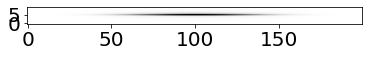

In [25]:
plt.imshow(np.abs(output_ft[1370:1380, 900:1100])**2, origin="lower", cmap="Greys")
plt.show()

0.9811482632053995
87
0.9811482632053997


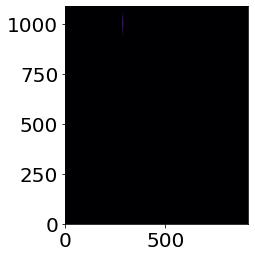

[9.77270606e-01 9.12153416e-03 4.20503500e-03 2.73034274e-03
 1.36538731e-03 1.06671443e-03 6.89911817e-04 5.81154125e-04
 4.55760567e-04 3.86130380e-04]
1.0000000000000004
0.9997633962988879
1.000236659695672


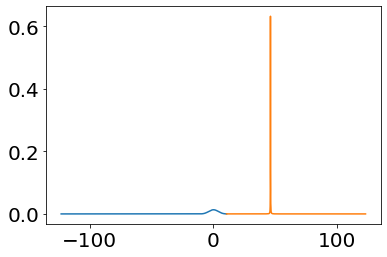

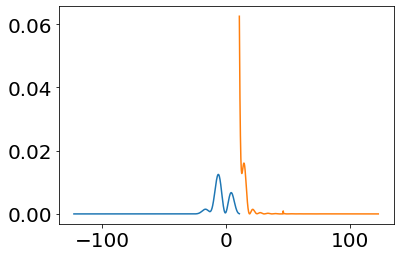

In [5]:
spectrum = np.abs(np.fft.fftshift(np.fft.fft2(output_2f)))**2
specSize = np.shape(spectrum)[0]

quad2sum = []
xrange = range(-int(specSize/3), int(specSize/3))
for x in xrange:
    quad2sum.append(np.sum(np.sum(spectrum[0:int(specSize/2)+x, int(specSize/2)+x:])))
print(2*np.max(quad2sum)/sum(sum(spectrum)))
print(xrange[np.argmax(quad2sum)])

offcenter = xrange[np.argmax(quad2sum)]
quad2 = spectrum[0:int(specSize/2)+offcenter, int(specSize/2)+offcenter:]

print(((2*sum(sum(quad2))) /sum(sum(spectrum))))

plt.imshow(quad2, origin="lower")
plt.show()

spectrumWF = np.fft.fftshift(np.fft.fft2(output_2f))
quad2WF = spectrumWF[0:int(specSize/2)+offcenter, int(specSize/2)+offcenter:]
quad2WF = quad2WF/np.sqrt(1*np.sum(np.sum(np.abs(quad2WF)**2)))

u, s, vh = np.linalg.svd(quad2WF)
print(s[0:10]/np.sum(s))

print(np.sum(s**2))
print(np.sum(s**4))
print(1/np.sum(s**4))

plt.plot(np.linspace(2*(0/2000*fsample - fsample/2), 2*((1000+offcenter)/2000*fsample - fsample/2), 1000+offcenter), np.abs(u[:,0])**2)
plt.plot(np.linspace(2*((1000+offcenter)/2000*fsample - fsample/2), 2*((2000)/2000*fsample - fsample/2), 1000-offcenter), np.abs(vh[0])**2)
plt.show()

plt.plot(np.linspace(2*(0/2000*fsample - fsample/2), 2*((1000+offcenter)/2000*fsample - fsample/2), 1000+offcenter), np.abs(u[:,1])**2)
plt.plot(np.linspace(2*((1000+offcenter)/2000*fsample - fsample/2), 2*((2000)/2000*fsample - fsample/2), 1000-offcenter), np.abs(vh[1])**2)
plt.show()


[4.92082670e-01 3.77946540e-01 1.13593391e-01 8.42850378e-03
 5.40559855e-03 1.24759814e-03 5.83550071e-04 3.63788937e-04
 1.52909568e-04 6.98622876e-05]
0.018363267389036337


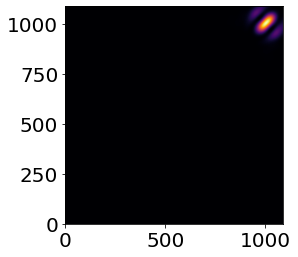

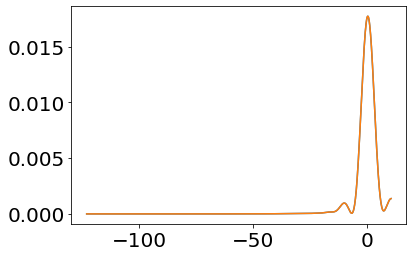

In [6]:
quad1 = spectrum[0:int(specSize/2)+offcenter, 0:int(specSize/2)+offcenter]

quad1WF = spectrumWF[0:int(specSize/2)+offcenter, 0:int(specSize/2)+offcenter]
quad1WF = quad1WF/np.sqrt(1*np.sum(np.sum(np.abs(quad1WF)**2)))

u, s, vh = np.linalg.svd(quad1WF)

print(s[0:10]/np.sum(s))
print(((sum(sum(quad1))) /sum(sum(spectrum))))

plt.imshow(quad1, origin="lower")
plt.show()

plt.plot(np.linspace(2*(0/2000*fsample - fsample/2), 2*((1000+offcenter)/2000*fsample - fsample/2), 1000+offcenter), np.abs(u[:,0])**2)
plt.plot(np.linspace(2*(0/2000*fsample - fsample/2), 2*((1000+offcenter)/2000*fsample - fsample/2), 1000+offcenter), np.abs(vh[0])**2)
plt.show()

[5.06969966e-01 4.87372268e-01 2.45510437e-03 1.22839231e-03
 9.92053535e-04 4.15015439e-04 2.96427211e-04 1.20651768e-04
 6.73320059e-05 3.58821960e-05]
0.000488469405564074


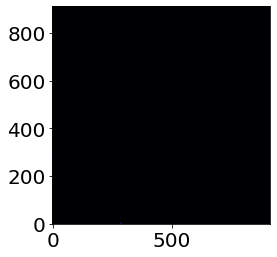

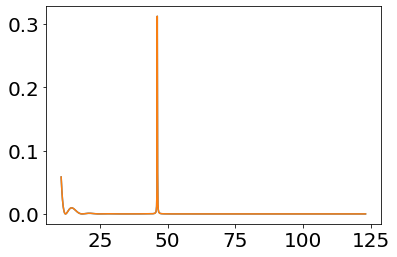

In [7]:
quad4 = spectrum[int(specSize/2)+offcenter:, int(specSize/2)+offcenter:]

quad4WF = spectrumWF[int(specSize/2)+offcenter:, int(specSize/2)+offcenter:]
quad4WF = quad4WF/np.sqrt(1*np.sum(np.sum(np.abs(quad4WF)**2)))

u, s, vh = np.linalg.svd(quad4WF)

print(s[0:10]/np.sum(s))
print(((sum(sum(quad4))) /sum(sum(spectrum))))

plt.imshow(quad4, origin="lower")
plt.show()

plt.plot(np.linspace(2*((1000+offcenter)/2000*fsample - fsample/2), 2*((2000)/2000*fsample - fsample/2), 1000-offcenter), np.abs(u[:,0])**2)
plt.plot(np.linspace(2*((1000+offcenter)/2000*fsample - fsample/2), 2*((2000)/2000*fsample - fsample/2), 1000-offcenter), np.abs(vh[0]**2))
plt.show()

[9.77270606e-01 9.12153416e-03 4.20503500e-03 2.73034274e-03
 1.36538731e-03 1.06671443e-03 6.89911817e-04 5.81154125e-04
 4.55760567e-04 3.86130380e-04]
0.9811482632053997


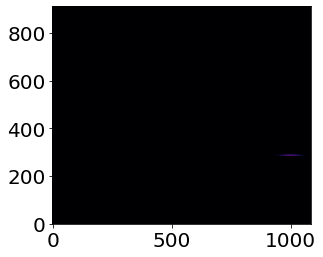

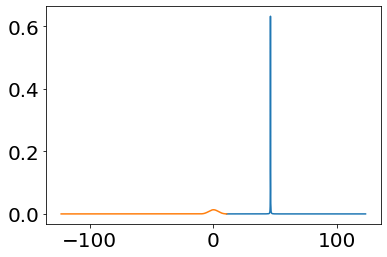

In [8]:
quad3 = spectrum[int(specSize/2)+offcenter:, 0:int(specSize/2)+offcenter]

quad3WF = spectrumWF[int(specSize/2)+offcenter:, 0:int(specSize/2)+offcenter]
quad3WF = quad3WF/np.sqrt(1*np.sum(np.sum(np.abs(quad4WF)**2)))

u, s, vh = np.linalg.svd(quad3WF)

print(s[0:10]/np.sum(s))
print(((2*sum(sum(quad3))) /sum(sum(spectrum))))

plt.imshow(quad3, origin="lower")
plt.show()

plt.plot(np.linspace(2*((1000+offcenter)/2000*fsample - fsample/2), 2*((2000)/2000*fsample - fsample/2), 1000-offcenter), np.abs(u[:,0])**2)
plt.plot(np.linspace(2*(0/2000*fsample - fsample/2), 2*((1000+offcenter)/2000*fsample - fsample/2), 1000+offcenter), np.abs(vh[0])**2)
plt.show()

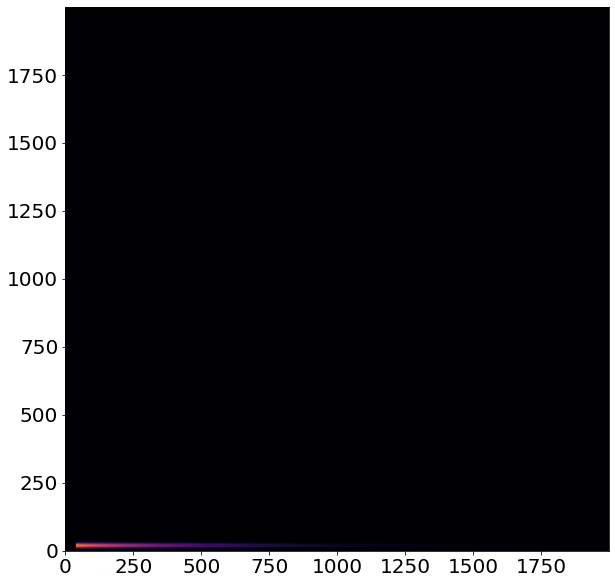

0.9996716272637833


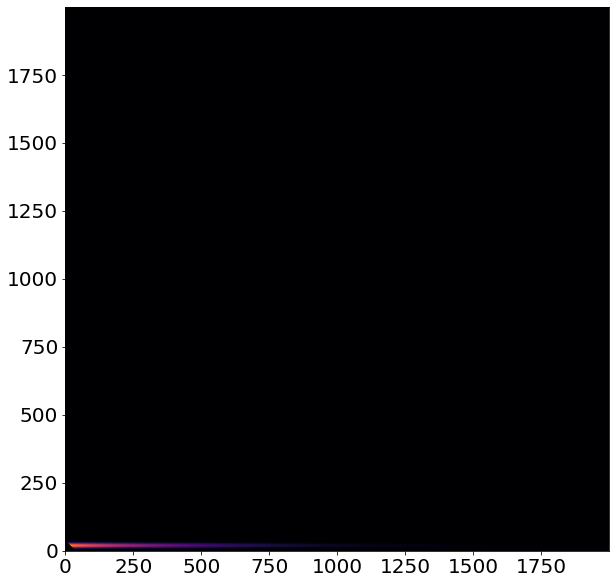

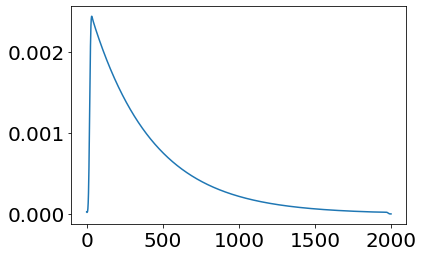

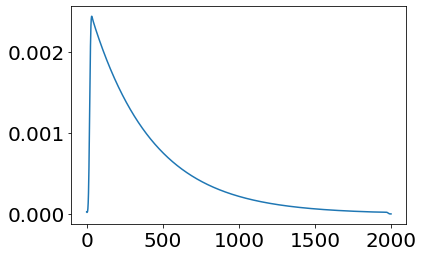

0.03544290265253616
0.03543126416961266
0.9996716272637826


In [9]:
spectrumFilt = np.zeros(np.shape(spectrumWF), dtype = 'complex')
spectrumFilt[0:int(specSize/2)+offcenter, int(specSize/2)+offcenter:] = spectrumWF[0:int(specSize/2)+offcenter, int(specSize/2)+offcenter:]
#spectrumFilt[int(specSize/2)+offcenter:, 0:int(specSize/2)+offcenter] = quad3WF
specShifted = np.fft.fftshift(spectrumFilt)
filt_g2 = np.fft.ifft2(specShifted)

plt.figure(figsize=(10,10))


plt.imshow(np.abs(filt_g2)**2, origin="lower")
plt.show()

filteredWFt = np.abs(filt_g2)**2

filteredWFt = filteredWFt / np.sum(np.sum(filteredWFt))

filteredWFtau = np.zeros(np.shape(filteredWFt))

for t1 in range(2000):
    for t2 in range(2000):
        if t2-t1 >= 0:
            filteredWFtau[t1, t2-t1] = filteredWFt[t1, t2]
        
print(np.sum(np.sum(filteredWFtau)))
        
plt.figure(figsize=(10,10))

plt.imshow(filteredWFtau, origin="lower")
plt.show()
        
g2Tau = np.zeros((2000,1))
for tau in range(2000):
    g2Tau[tau] = np.sum(np.diagonal(filteredWFt, offset = tau))#*(times[-1] / len(times))
    
plt.plot(g2Tau)
plt.show()

plt.plot(np.sum(filteredWFtau, axis = 0))
plt.show()



    
print(np.sum(np.sum(np.abs(filt_g2)**2))*(times[-1] / len(times))**2)
print(np.sum(np.sum(np.triu(np.abs(filt_g2)**2)))*(times[-1] / len(times))**2)
print(np.sum(np.sum(np.triu(np.abs(filt_g2)**2)))*(times[-1] / len(times))**2/(np.sum(np.sum(np.abs(filt_g2)**2))*(times[-1] / len(times))**2))

In [10]:
def optSeparability(args):
    gamma = 1 #98 * 1e-3
    
    arg_ptime = args[0]
    arg_pamp = args[1]
    arg_pw = args[2]

    pulsetimes = [-1000, arg_ptime / gamma] #0.075 / gamma]

    pulseamps = [0, arg_pamp]

    delta_2f = pulse.ArbPulseConst(pulsetimes, pulseamps)

    tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_2f)

    pulse_width = arg_pw / gamma
    pulse_area = np.pi*2*1/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

    pulse_amp = pulse_area / (2 * pulse_width)
    laser_pulse = RectangularPulse(pulse_amp, pulse_width)

    times = np.linspace(0, 5 / gamma, 250)
    output_2f = two_photon_emission.two_photon_emission(
            tls_obj_2f, times, laser_pulse, 1)
    
    spectrum = np.abs(np.fft.fftshift(np.fft.fft2(output_2f)))
    specSize = np.shape(spectrum)[0]

    quad2sum = []
    xrange = range(-int(specSize/3), int(specSize/3))
    for x in xrange:
        quad2sum.append(np.sum(np.sum(spectrum[0:int(specSize/2)+x, int(specSize/2)+x:])))
    print(2*np.max(quad2sum)/sum(sum(spectrum)))
    return -(2*np.max(quad2sum)/sum(sum(spectrum)))
    
    

In [22]:
x0 = np.array([0.12, -120, 0.12])

inSimp = np.array([x0, x0+np.array([-0.05,0,0]), x0+np.array([0,80,0]), x0+np.array([0,0,-0.05])])

res = minimize(optSeparability, x0, method='Nelder-Mead', options={'initial_simplex':inSimp , 'disp': True})

print(res.x)

0.693199076617981
0.6788201642072624
0.640830446391064
0.5596568300820568
0.6139711069326002
0.7001962317510394
0.6722523100990266
0.665081959296615
0.6641801682449628
0.6713123603351693
0.7658117409842973
0.6153261970238068
0.6741450112607583
0.7626272341052505
0.7279350654441135
0.6157527141773385
0.747339069657099
0.7036136990658045
0.7559798222929851
0.7387010364195935
0.7609963228617026
0.7620153723190293
0.7556554049308474
0.762645068500635
0.7557011947840093
0.7676760625264922
0.7745257310869956
0.7735085058289566
0.777970654507985
0.7732865671646888
0.7777683513112381
0.7736130883800598
0.7814238299225768
0.7821286150154086
0.773474938548943
0.7800796434720834
0.7742103269119108
0.7721866433719504
0.7817949007732194
0.7812966616258848
0.7803443945882036
0.7789588703211582
0.7761252137893606
0.7819665876657022
0.7744408057334914
0.7813123441401428
0.7771491335413974
0.7746776528848784
0.7820488286279642
0.7741482989858122
0.7747575411741914
0.7788197016537882
0.7745862203836477


In [12]:
deltaT = times[1]-times[0]
Heff = np.array([[0,31],[31, 0-0.5j]])
scipy.linalg.expm(-1.0j * Heff * deltaT)

array([[0.70422989+0.j       , 0.        -0.7066872j],
       [0.        -0.7066872j, 0.69283171+0.j       ]])

In [13]:
delta = 1e-3
deltaW = np.array([[0,0],[0,1]])*delta
(scipy.linalg.expm(-1.0j * (Heff+deltaW) * deltaT) - scipy.linalg.expm(-1.0j * (Heff-deltaW) * deltaT))/(2*delta)

array([[ 0.        +0.00248405j, -0.00899834+0.j        ],
       [-0.00899834+0.j        ,  0.        -0.02016717j]])

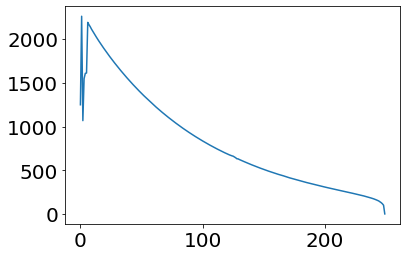

In [19]:
gamma = 1
    
# arg_ptime = 0.1
# arg_pamp = -50
# arg_pw = 0.1
arg_ptime = res.x[0]
arg_pamp = res.x[1]
arg_pw = res.x[2]

pulsetimes = [-1000, arg_ptime / gamma]

pulseamps = [100, arg_pamp]

delta_2f = pulse.ArbPulseConst(pulsetimes, pulseamps)

tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta_2f)

pulse_width = arg_pw / gamma
pulse_area = np.pi*2*1/np.sqrt(gamma) #* 1/0.75 *1.2775 # *2.9375

pulse_amp = pulse_area / (2 * pulse_width)
laser_pulse = RectangularPulse(pulse_amp, pulse_width)

times = np.linspace(0, 5 / gamma, 250)
output_2f = two_photon_emission.two_photon_emission(
        tls_obj_2f, times, laser_pulse, 1)


objective = np.ones((times.size, times.size))

grad = two_photon_emission.two_photon_emission_gradient(tls_obj_2f, times, laser_pulse, 1, objective)
# print(grad)
# print(np.shape(grad))
plt.plot(grad)
plt.show()

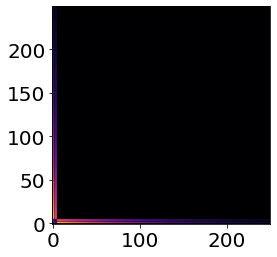

In [20]:
plt.imshow(np.abs(output_2f), origin="lower")

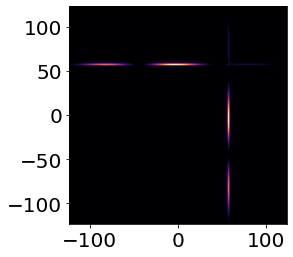

In [21]:
plt.imshow((np.abs(np.fft.fftshift(np.fft.fft2(output_2f)))**2), origin="lower",# cmap = 'bwr',
          extent=[-fsample, fsample, -fsample, fsample])